# COVID-19 xray scan model
This model will help us to determine whether a patient has COVID-19 or any other similar disease or not. This project may be very helpful as it will provide an easy approach solution to diagnosis COVID-19 and other similar diseases at hospitals.

In [1]:
# import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import shutil
import random
import cv2
import argparse
import os

In [2]:
# setting up kaggle dataset import in colab
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ankitoscar","key":"69949c96a29312719879801fab7c7cea"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete             World Health 2020 🌏 | For Geospatial Analysis         1MB  2021-01-03 16:20:42            420  
gpreda/pfizer-vaccine-tweets                                   Pfizer Vaccine Tweets                               363KB  2021-01-03 20:16:38            254  
google/android-smartphones-high-accuracy-datasets              Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11             58  
ashkhagan/women-representation-in-city-property-sanfrancisco   Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14             55  
arashnic/covid19-case-surveillance-public-use-

In [7]:
# downloading dataset from kaggle link
!kaggle datasets download -d bachrr/covid-chest-xray

 93% 225M/241M [00:01<00:00, 120MB/s]
100% 241M/241M [00:02<00:00, 120MB/s]


In [8]:
!mkdir covid19-x-ray

In [9]:
!unzip covid-chest-xray.zip -d covid19-x-ray

Archive:  covid-chest-xray.zip
  inflating: covid19-x-ray/annotations/imageannotation_ai_lung_bounding_boxes.json  
  inflating: covid19-x-ray/images/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: covid19-x-ray/images/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: covid19-x-ray/images/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr3_lrg-a.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr3_lrg-b.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr3_lrg-c.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300449-gr3_lrg-d.jpg  
  inflating: covid19-x-ray/images/1-s2.0-S0929664620300

# Analysis of COVID Dataset
Here, we will see features of the dataset which we have in hand for modelling.

In [10]:
# importing metadata csv file
eda = pd.read_csv('covid19-x-ray/metadata.csv')

In [11]:
eda.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [12]:
# numerical stats of the dataset
eda.describe()

,patientid,offset,age,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count
count,372.000000,276.000000,318.000000,35.000000,44.000000,11.000000,2.000000,10.000000
mean,100.362903,6.641304,55.993711,39.794286,87.961364,5.454545,3.590000,0.879100
std,62.066915,7.155288,15.779233,9.641087,11.187435,2.954828,2.771859,0.440806
min,2.000000,-5.000000,12.000000,36.400000,50.000000,0.220000,1.630000,0.131000
25%,42.750000,2.000000,45.000000,37.800000,84.750000,3.140000,2.610000,0.647500
50%,96.500000,5.000000,56.000000,38.000000,92.000000,6.370000,3.590000,0.800000
75%,159.250000,9.000000,70.000000,38.950000,96.000000,6.875000,4.570000,1.125000
max,205.000000,35.000000,88.000000,95.000000,98.000000,11.200000,5.550000,1.730000


In [13]:
# number of null values in dataset
eda.isna().sum()

patientid                   0
offset                     96
sex                        43
age                        54
finding                     0
survival                  256
intubated                 300
intubation_present        295
went_icu                  337
in_icu                    365
needed_supplemental_O2    360
extubated                 349
temperature               337
pO2_saturation            328
leukocyte_count           361
neutrophil_count          370
lymphocyte_count          362
view                        0
modality                    0
date                       81
location                  118
folder                      0
filename                    0
doi                       268
url                         0
license                   166
clinical_notes             10
other_notes               138
Unnamed: 28               368
dtype: int64

The dataset seems to have a lot of null values in various fields, except finding which is very important.

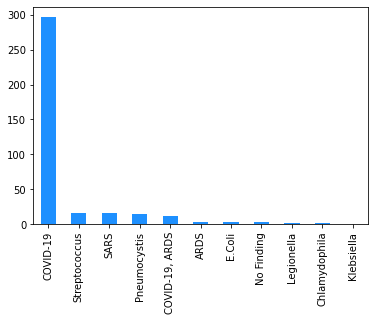

In [14]:
# plot showing distribution of findings
eda['finding'].value_counts().plot.bar(color='dodgerblue');

An overwhelming number of images in the dataset have COVID-19 marked as finding, which is helpful as our project is focused on COVID-19.

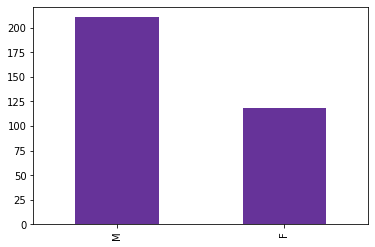

In [15]:
# plot showing distribution of sex
eda['sex'].value_counts().plot.bar(color='rebeccapurple');

There are more male patients than female ones in the dataset.

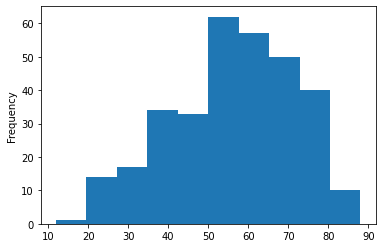

In [16]:
# plot showing distribution of age
eda['age'].plot.hist();

This plot shows that majority of the patients are older than 60 years.

## Creating Dataset

In [17]:
# construct path to metadata.csv and load it
covid_19_path = 'covid19-x-ray'
dataset_path = 'dataset'

In [18]:
# continue from previous cell
csvPath = os.path.sep.join([covid_19_path,'metadata.csv'])
df = pd.read_csv(csvPath)

In [75]:
# loop over the rows of the COVID-19 dataframe
for (i,row) in df.iterrows():
  # if (1) the current case is not COVID-19 or (2) this is not a 'PA' view
  #then ignore
  if row['finding'] != "COVID-19" or row['view'] != "PA":
    continue

  # build the path to the input image file
  imagePath = os.path.sep.join([covid_19_path,"images",row["filename"]])

  # if the input file doesn't exist, ignore the row
  
  if not os.path.exists(imagePath):
    continue

  # extract the filename from the image path and then construct the path
  # to the copied image file
  filename = row["filename"].split(os.path.sep)[-1]
  outputPath = os.path.sep.join([f"{dataset_path}/covid",filename])

  # copy the image
  shutil.copy2(imagePath,outputPath)

## X-ray show
Let's see the x-ray scans of COVID-19 patients.

In [24]:
def ceildiv(a,b):
  return -(-a // b)

# function to show plots of x-ray scans
def plot_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
  """
  Plots the images in a grid
  """
  f = plt.figure(figsize=figsize)
  if maintitle is not None: plt.suptitle(maintitle, fontsize=18)
  for i in range(len(imspaths)):
    sp = f.add_subplot(rows, ceildiv(len(imspaths),rows),i+1)
    sp.axis("Off")
    if titles is not None: sp.set_title(titles[i], fontsize=16)
    img = plt.imread(imspaths[i])
    plt.imshow(img)

  
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

In [25]:
# showing covid x-ray scans
plot_from_files(covid_images, rows=5, maintitle="COVID-19 X-ray scans");

<Figure size 720x360 with 0 Axes>

In [26]:
# importing other images
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia -d covid19-x-ray

Streaming output truncated to the last 5000 lines.
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: covid19-x-ray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
 

In [28]:
# iterating over these other images
pneumonia_dataset_path = 'covid19-x-ray/chest_xray'
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  # extract the filename from the image path and 
  # then construct the path of copied image file
  filename = imagePath.split(os.path.sep)[-1]
  outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

  #copy the image
  shutil.copy2(imagePath,outputPath)

In [30]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  # extract the filename from the image path and 
  # then construct the path of copied image file
  filename = imagePath.split(os.path.sep)[-1]
  outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])

  #copy the image
  shutil.copy2(imagePath,outputPath)

In [73]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
pneumonia_images = list(paths.list_images(f"{dataset_path}/pneumonia"))

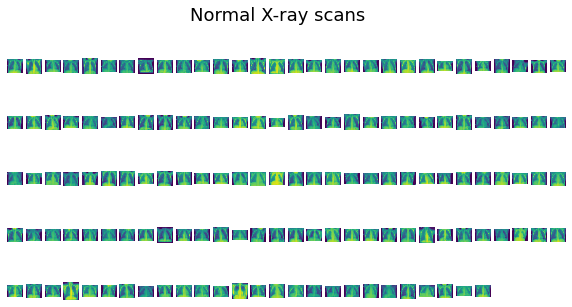

In [74]:
plot_from_files(normal_images, rows=5, maintitle="Normal X-ray scans")

In [33]:
plot_from_files(pneumonia_images, rows=5, maintitle="Pneumonia X-ray Scans")

<Figure size 720x360 with 0 Axes>

## Data Preprocessing

In [34]:
# initial some important variables
INIT_LR = 1e-3 # learning rate
EPOCHS = 100
BS = 8

In [80]:
# lets take the labels of each image in the directory to make a classification
print("[INFO] loading images.....")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  # load the image, swap color channels and resize it to be a fixed
  # 224x224 pixels while ignoring aspect ratio
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224,224))
  
  # update the data and labels lists, repectively
  data.append(image)
  labels.append(label)


# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0,1]

data = np.array(data) / 255.0
labels = np.array(labels)
print("[INFO] Images successfully loaded")

[INFO] loading images.....
[INFO] Images successfully loaded


In [81]:
# creating a one-hot encoding to the list of the labels to make the classification
# integer encode
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)

# Split the data into training and testing with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                  stratify=labels, random_state=42)

# Set the image augmentation of the training data
trainAug = ImageDataGenerator(rotation_range=15, fill_mode='nearest')

## Making the model VGG16

In [82]:
labels.shape,X_test.shape,y_test.shape

((433, 3), (87, 224, 224, 3), (87, 3))

In [64]:
# loading weights of VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='Flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(3, activation='softmax')(head_model)

In [67]:
model = Model(inputs= base_model.input, outputs= head_model)
for layers in base_model.layers:
  layers.trainable = False

opt = Adam(lr = INIT_LR, decay= INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [68]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [43]:
X_test.shape, y_test.shape

((59, 224, 224, 3), (59, 2))

In [83]:
# training the model

with tf.device('/gpu:0'):
  print("Training the model with gpu...")
  training = model.fit_generator(trainAug.flow(X_train,y_train, batch_size=BS),
                                 steps_per_epoch=len(X_train) // BS, validation_data=(X_test,y_test),
                                 validation_steps=len(X_test) // BS, epochs=100)

Training the model with gpu...
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


43/43 [==============================] - 215s 5s/step - loss: 0.6406 - accuracy: 0.3994 - val_loss: 0.5881 - val_accuracy: 0.6897
Epoch 2/100
43/43 [==============================] - 214s 5s/step - loss: 0.5676 - accuracy: 0.5828 - val_loss: 0.5374 - val_accuracy: 0.6667
Epoch 3/100
43/43 [==============================] - 215s 5s/step - loss: 0.5256 - accuracy: 0.6805 - val_loss: 0.4945 - val_accuracy: 0.8276
Epoch 4/100
43/43 [==============================] - 214s 5s/step - loss: 0.4923 - accuracy: 0.6953 - val_loss: 0.4659 - val_accuracy: 0.8391
Epoch 5/100
43/43 [==============================] - 213s 5s/step - loss: 0.4628 - accuracy: 0.7278 - val_loss: 0.4255 - val_accuracy: 0.8046
Epoch 6/100
43/43 [==============================] - 214s 5s/step - loss: 0.4404 - accuracy: 0.7426 - val_loss: 0.3987 - val_accuracy: 0.8621
Epoch 7/100
43/43 [==============================] - 214s 5s/step - loss: 0.3953 - accuracy: 0.8018 - val_loss: 0.3745 - val_accuracy: 0.8506
Epoch 8/100
43/43 

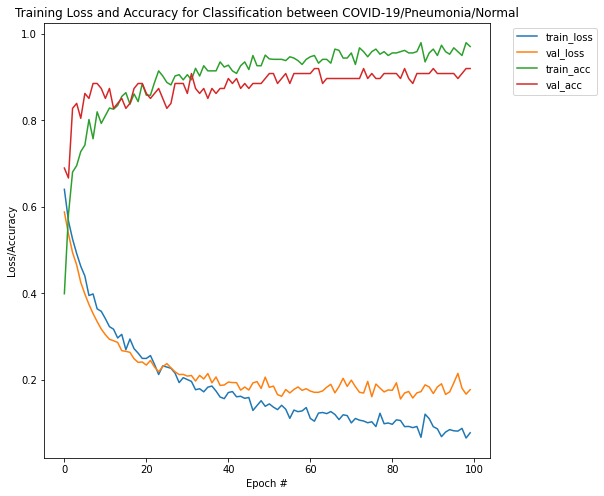

In [85]:
# plot the training loss and accuracy
N = EPOCHS
plt.figure(figsize=(8,8))
plt.plot(np.arange(0,N), training.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), training.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), training.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), training.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy for Classification between COVID-19/Pneumonia/Normal")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right",bbox_to_anchor=(1.25,1))

In [86]:
# predicting on test set
print("[INFO] evalauting network...")
predIdxs = model.predict(X_test, batch_size=BS)
# find index of label with highest probability in test set
predIdxs = np.argmax(predIdxs, axis=1)
# classification report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=
                            lb_encoder.classes_))

[INFO] evalauting network...
              precision    recall  f1-score   support

       covid       0.93      1.00      0.97        28
      normal       0.85      0.97      0.90        29
   pneumonia       1.00      0.80      0.89        30

    accuracy                           0.92        87
   macro avg       0.93      0.92      0.92        87
weighted avg       0.93      0.92      0.92        87



In [88]:
# compute the confusion matrix and use it to derive raw metrics
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])
# show these metrics 
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

Accuracy: 0.6437
Sensitivity: 1.0000
Specificity: 0.9655


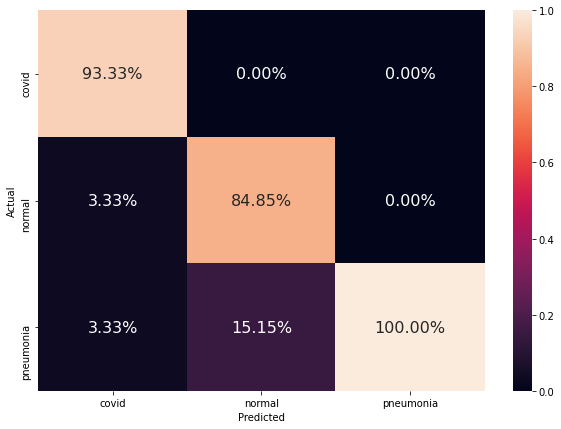

In [90]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=lb_encoder.classes_, index=lb_encoder.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot=True, annot_kws={'size':16})
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

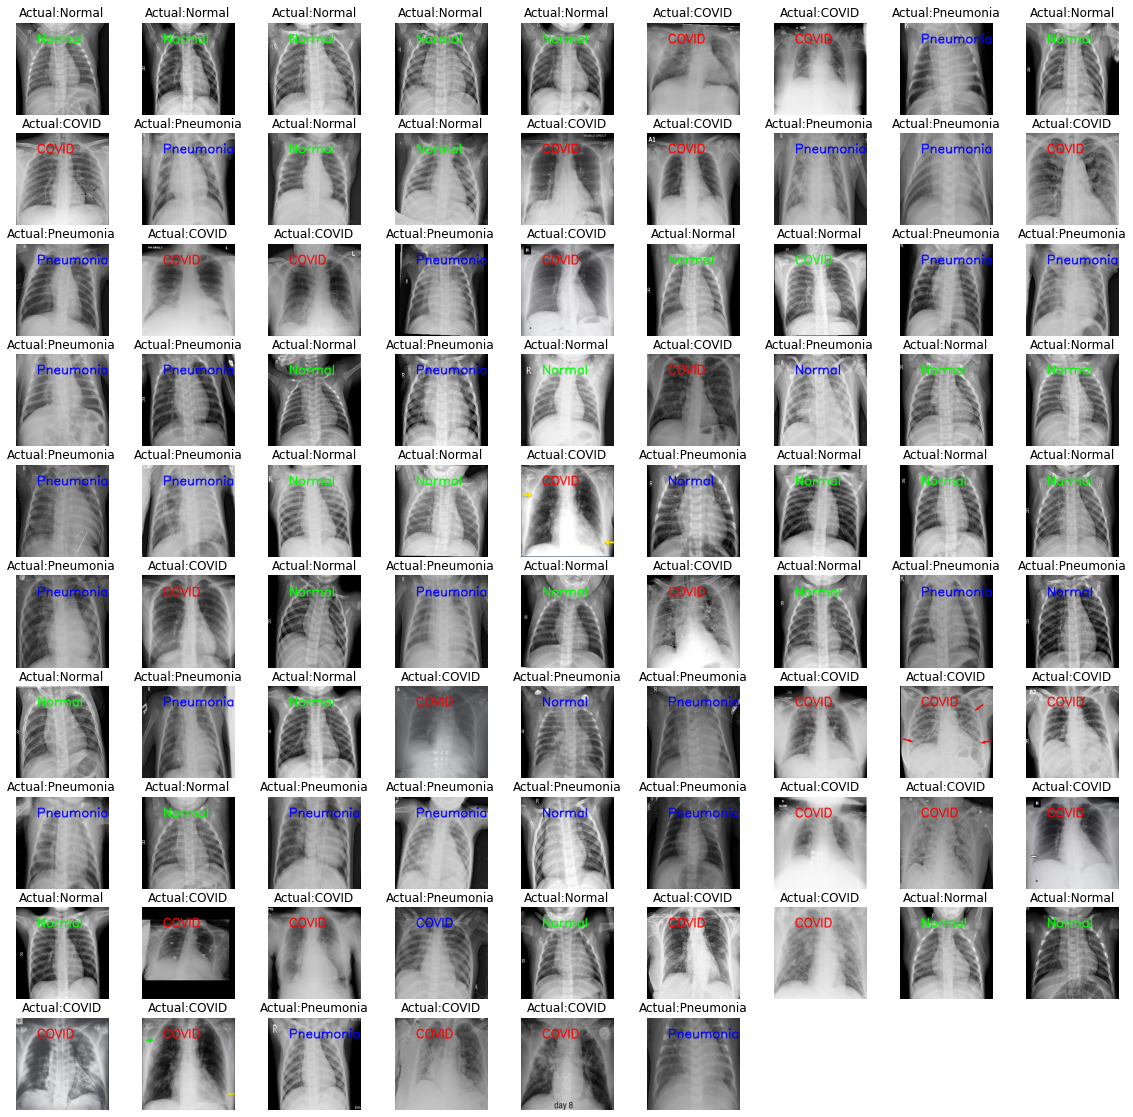

In [91]:
rows = 10
columns = 9
fig = plt.figure(figsize=(20,20))
for m in range(1,88):
  if str(lb_encoder.inverse_transform(predIdxs)[m-1]) == 'covid':
    text = "COVID"
    color = (255,0,0)
  elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == 'normal':
    text = "Normal"
    color = (0,255,0)
  elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == 'pneumonia':
    text = "Pneumonia"
    color = (0,0,255)

  if str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == 'covid':
    text2 = 'COVID'
    color = (255,0,0)
  elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == 'normal':
    text2 = "Normal"
    color = (0,255,0)
  elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == 'pneumonia':
    text2 = "Pneumonia"
    color = (0,0,255)

  img = X_test[m-1].copy()
  # window name in which image is displayed
  window_name = text

  # font
  font = cv2.FONT_HERSHEY_SIMPLEX

  # org
  org = (50,50)

  # fontscale
  fontScale = 1

  # Line thickness of 2 px
  thickness = 2
  img = cv2.putText(img, text, org, font, fontScale, color,
                    thickness, cv2.LINE_AA)
  fig.add_subplot(rows, columns, m)
  plt.imshow(img)
  plt.title("Actual:" + text2)
  plt.axis("off")

plt.show()

In [92]:
# exporting model to drive
model.save('/content/drive/MyDrive/covid-19-xray-model.hdf5')